Лабораторная работа № 9: **Кластеризация** <br>
Выполнил: **Стадников Александр, гр.6135**

In [1]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

---
---
## 0. Найти датасет для кластеризации:


> `для этого берём датасет для мультиклассовой классификации и временно убираем метки классов. Эти метки классов пригодятся нам для оценки качества кластеризации. Хотя в реальной жизни такой роскоши скорее всего не будет, однако наличие априорного знания о кластерах позволит нам посчитать несколько дополнительных метри`

## Описание данных

**Исходные данные:** https://www.kaggle.com/deepu1109/star-dataset <br><br>
**Набор данных: "Космические звёзды"**<br>
Этот датасет содержит характеристики звёзд. <br><br>
Цель создания набора данных - доказать, что звезды следуют определенному графику в небесном пространстве, специально называемая диаграммой Герцшпрунга-Рассела или просто HR-диаграммой так что мы можем классифицировать звезды, нанося их характеристики на основе этого графика. <br>

Набор данных, состоящий из нескольких характеристик звезд. 
Некоторые из них: 
- Абсолютная температура (в К) 
- Относительная яркость (L / Lo)
- Относительный радиус (R / Ro) 
- Абсолютная величина (Mv) 
- Цвет звезды (белый, красный, синий, желтый, желто-оранжевый и т. Д.) - Спектральный класс (O, B, A, F, G, K ,, M) 
- Тип звезды **(красный карлик, коричневый карлик, белый карлик, основная последовательность, сверхгиганты, гипергиганты)** 



---


Lo = 3,828 x 10 ^ 26 Вт (средняя яркость Солнца) <br>
Ro = 6,9551 x 10 ^ 8 м (средний радиус Солнца)



---

- Brown Dwarf -> Star Type = 0
- Red Dwarf -> Star Type = 1
- White Dwarf-> Star Type = 2
- Main Sequence -> Star Type = 3
- Supergiant -> Star Type = 4
- Hypergiant -> Star Type = 5

In [2]:
df = pd.read_csv(r'Stars.csv')
df.head(240)

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Blue,O,5
236,30839,834042.000000,1194.0000,-10.63,Blue,O,5
237,8829,537493.000000,1423.0000,-10.73,White,A,5
238,9235,404940.000000,1112.0000,-11.23,White,A,5


In [3]:
df.isna().sum()

Temperature       0
L                 0
R                 0
A_M               0
Color             0
Spectral_Class    0
Type              0
dtype: int64

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,240.0,10497.462500,9552.425037,1939.00000,3344.250000,5776.0000,15055.5000,40000.00
L,240.0,107188.361635,179432.244940,0.00008,0.000865,0.0705,198050.0000,849420.00
R,240.0,237.157781,517.155763,0.00840,0.102750,0.7625,42.7500,1948.50
A_M,240.0,4.382396,10.532512,-11.92000,-6.232500,8.3130,13.6975,20.06
Type,240.0,2.500000,1.711394,0.00000,1.000000,2.5000,4.0000,5.00


In [5]:
df.Color, _ = pd.factorize(df.Color)
df.Spectral_Class, _ = pd.factorize(df.Spectral_Class)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     240 non-null    int64  
 1   L               240 non-null    float64
 2   R               240 non-null    float64
 3   A_M             240 non-null    float64
 4   Color           240 non-null    int64  
 5   Spectral_Class  240 non-null    int64  
 6   Type            240 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 13.2 KB


In [6]:
y = df['Type']
X = df.drop(columns=['Type'])

## 1. Производим иерархическую агломеративную кластеризацию

In [7]:
hier = linkage(X, method='complete', metric='euclidean')
hier.shape

(239, 4)

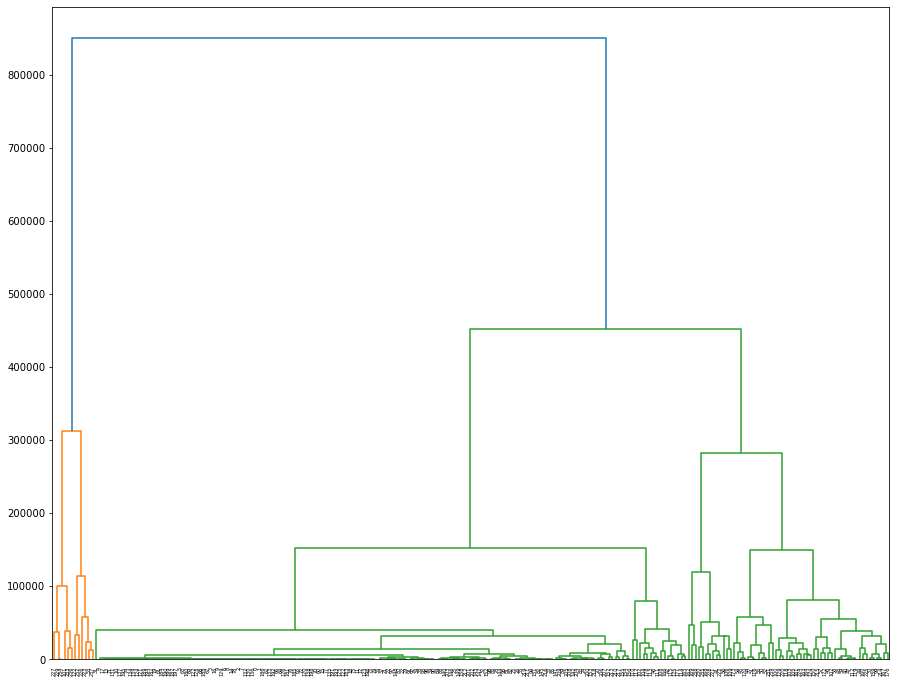

In [8]:
plt.figure(figsize=(15, 12))
dendrogram(hier,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.show()

## 2. На том же датасете производим кластеризацию, используя любой другой метод кластеризации (пока с произвольными гиперпараметрами)

In [9]:
from sklearn.metrics import *

In [10]:
def getMetric(X, y, algo):
    metrics={
        'ARI': adjusted_rand_score(y, algo.labels_),
        'AMI': adjusted_mutual_info_score(y, algo.labels_),
        'Homogenity': homogeneity_score(y, algo.labels_),
        'Completeness': completeness_score(y, algo.labels_),
        'V-measure': v_measure_score(y, algo.labels_),
        'Silhouette': silhouette_score(X, algo.labels_)
    }
    return metrics

In [11]:
estimator = KMeans()

In [12]:
%%time
clusters = estimator.fit_predict(X)
np.unique(clusters, return_counts=True)

Wall time: 66 ms


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([154,  14,   6,  22,   6,  16,  19,   3], dtype=int64))

In [13]:
getMetric(X, y, estimator)

{'ARI': 0.17471989412897326,
 'AMI': 0.3702252825454581,
 'Homogenity': 0.3476114353035825,
 'Completeness': 0.4828027710108607,
 'V-measure': 0.4042025363330135,
 'Silhouette': 0.7962065521580826}

## 3. Оптимизация гиперпараметров KMeans (по гомогенности)

In [14]:
params = {'n_clusters': range(2, 16), 'max_iter': range(200, 500, 50), 'tol': [0.0001, 0.001, 0.01]}

In [15]:
grid_KMeans = GridSearchCV(KMeans(), params, scoring='homogeneity_score', cv=5)

In [16]:
%%time
grid_KMeans.fit(X, y)

Wall time: 1min 22s


GridSearchCV(cv=5, estimator=KMeans(),
             param_grid={'max_iter': range(200, 500, 50),
                         'n_clusters': range(2, 16),
                         'tol': [0.0001, 0.001, 0.01]},
             scoring='homogeneity_score')

In [17]:
grid_KMeans.best_params_

{'max_iter': 300, 'n_clusters': 15, 'tol': 0.0001}

In [18]:
np.unique(grid_KMeans.best_estimator_.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([ 13, 114,   3,   6,  14,   3,  12,   8,   8,   3,   3,   2,   8,
          3,  40], dtype=int64))

In [19]:
getMetric(X, y, grid_KMeans.best_estimator_)

{'ARI': 0.24305707370978044,
 'AMI': 0.41067049027982494,
 'Homogenity': 0.4742070478128645,
 'Completeness': 0.4539224002296743,
 'V-measure': 0.4638430593987094,
 'Silhouette': 0.6258382861508884}

## 4. Используя алгоритм/модель из п. 2 произвести оптимизацию гиперпараметра количества кластеров, используя "правило локтя" (анализируем график силуэта)

In [20]:
scores = []

for n_clusters in range(2, 25):
    clusters = KMeans(n_clusters=n_clusters, max_iter=200, tol=0.0001).fit_predict(X)
    scores.append(silhouette_score(X, clusters))

Text(0, 0.5, 'silhouette score')

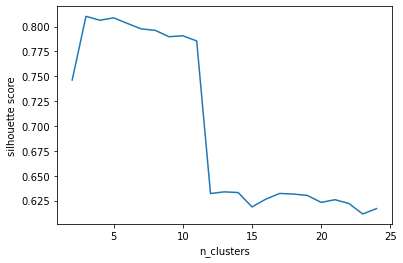

In [21]:
plt.plot(range(2, 25), scores)
plt.xlabel('n_clusters')
plt.ylabel('silhouette score')